<span style="font-size:10pt">Copyright Jean-Luc CHARLES $-$ 2025/03/14 $-$ CC BY-SA 4.0 $-$  <img src="img/CC-BY-SA.jpeg" width="50"></span> 

# Training Reproducibility with tensorflow

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
    It is fundamental to use a <span style="font-weight:bold;">Python Virtual Environment</span> (PVE) for each important Python project: the PVE makes it possible to control for each project the versions of the Python interpreter and "sensitive" modules (like tensorflow for example).</span></div>

This notebook should be run with tensorflow 2.16.2

## 1 - Import the required Python modules

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #suppress the numerous TensorFlow warnings

import tensorflow as tf
from tensorflow import keras

import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
from time import time
from cpuinfo import get_cpu_info

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# specific modules:
from utils.tools import scan_dir, plot_images, plot_loss_accuracy, elapsed_time_since, show_conf_matrix, plot_proportion_bar

print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} with keras {keras.__version__}")
print(f"numpy     : {np.__version__}")
print(f"OpenCV    : {cv2.__version__}")

Python    : 3.12.3
tensorflow: 2.16.2 with keras 3.8.0
numpy     : 1.26.4
OpenCV    : 4.11.0


In [2]:
# allows to visualize the graphs directly in the cell of the notebook:
%matplotlib inline

Unless explicitly stated, we use this seed value to make reproducible the random generators:

In [3]:
SEED = 1234

## 2 - Reproducibility of pseudo-random generators <a name="2"></a>

The weights of a neural network are initialized by __random values__ : when pseudo-random generators are invoked several times in succession, different random sequence are created at each invocation. For example with `numpy.random.rand`:

In [4]:
import numpy as np
for _ in range(5):
    print(np.random.rand(6))

[0.76115545 0.34758119 0.52571054 0.15295794 0.15950657 0.51222472]
[0.13227483 0.49246874 0.42586761 0.56723665 0.49912546 0.38033724]
[0.07171786 0.49566983 0.56254636 0.01266717 0.91392766 0.49843471]
[0.4827509  0.28019941 0.20194243 0.29275074 0.29804042 0.12697602]
[0.42115901 0.70891163 0.69102591 0.92058956 0.145961   0.89569185]


<span style="color:brown">This behavior can be very inappropriate when studying the performance of a trained network as a function of meta-parameters:<br>every time you run the training of the neural network (runing the cell or the notebook) with different values of the meta-parameters, you get a different initial state of the network, leading to a different training network...
</spawn>

### The seed of random generators

The technical solution to get a reproducible random sequence from a (pseudo) random generator is to set the __seed__ of the generator.<br>

The following cells illustrate the mechanism:

In [5]:
for _ in range(5):
    np.random.seed(1234)
    print(np.random.rand(5))

[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]


<span style="color:brown">Setting the __seed__ ensure that the random sequence is the same even on other computers (Windows, Mac, Linux...).<br>
    The figure bellow comes from a Windows10 machine :
</spawn>
![img/seed_1234_w10.png](img/seed_1234_w10.png)

Of course if you change the seed you get a different random sequence:

In [6]:
for _ in range(5):
    np.random.seed(2345)
    print(np.random.rand(5))

[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]


## 3 - Load the MNIST dataset (images and labels)

We use the keras `load_data` function to load the data from the MNIST 
(see [tf.keras.datasets.mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data)):<br>
- `im_train`, `lab_train` are the training images and labels,
- `im_valid`, `lab_valid` are the validation images and labels.

In [7]:
(im_train, lab_train), (im_valid, lab_valid) = keras.datasets.mnist.load_data()

Let's check the `shape` and `dtype` attributes of the numpy arrays:

In [8]:
print(f"im_train.shape:  {im_train.shape}, dtype: {im_train.dtype}")
print(f"im_valid.shape:  {im_valid.shape}, dtype: {im_valid.dtype}")
print(f"lab_train.shape: {lab_train.shape}, dtype: {lab_train.dtype}")
print(f"lab_vaild.shape: {lab_valid.shape}, dtype: {lab_valid.dtype}")

im_train.shape:  (60000, 28, 28), dtype: uint8
im_valid.shape:  (10000, 28, 28), dtype: uint8
lab_train.shape: (60000,), dtype: uint8
lab_vaild.shape: (10000,), dtype: uint8


### Visualization of images and labels:

The local module `utils.tools` defines the `plot_images` function which can be used to diplay a grid of MINIT images.<br>
Let's plot a grid of images 4 x 6 geginning with the 600th image:

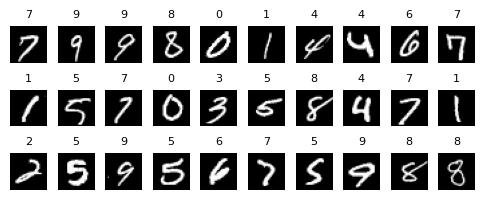

In [9]:
plot_images(im_train, 3, 10, 599, label_array=lab_train)

### Create the 3 datasets: train, validation & test

To follow the _state of the art_, we will split the whole dataset into train, validation & test datasets.<br>
A simple way to do this is to keep the train dataset and to split of the current validation dataset in two equal subsets:
- a new smaller validation set,
- a new test set.

In [10]:
# note on train_test_split : Stratified train/test split is not implemented for shuffle=False 

im_valid, im_test, lab_valid, lab_test = train_test_split(im_valid, lab_valid,
                                                          stratify=lab_valid,
                                                          test_size=0.5,
                                                          shuffle=True,
                                                          random_state=SEED)

Let's check the sizes of the 3 datasets:

In [11]:
print(f'train:  {im_train.shape}')
print(f'valid:  {im_valid.shape}')
print(f'test :  {im_test.shape}')

train:  (60000, 28, 28)
valid:  (5000, 28, 28)
test :  (5000, 28, 28)


We can verify that the proportion of digits remains homogenous in all the datasets:

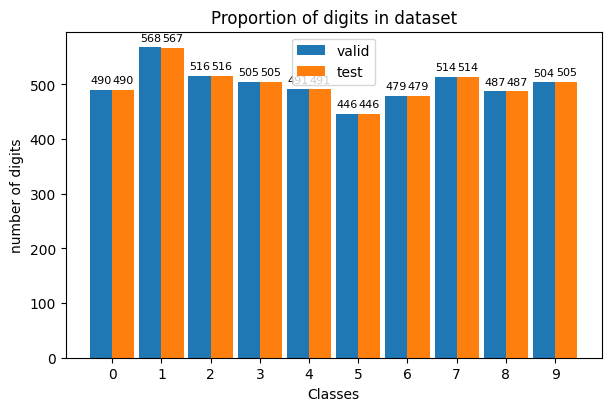

In [12]:
prop = {}
prop['valid'] = [ (lab_valid == i).sum() for i in range(10)]
prop['test']  = [ (lab_test  == i).sum() for i in range(10)]
plot_proportion_bar(prop, range(10))

### Setting useful parameters:

To avoid hard-coding the number of training, validation & test images as well as the size of the images, these numbers are recovered from the data set:
- with the shape attribute of the image arrays;
- with the size attribute of the first training image for example.

In [13]:
# number of training images:
NB_IM_TRAIN = im_train.shape[0]
NB_IM_VALID = im_valid.shape[0]     
NB_IM_TEST  = im_test.shape[0]     

# image shape:
IM_SHAPE = im_train[0].shape

# number of elements (pixels) of the firts training image: 
NB_PIXEL    = im_train[0].size   

# Visual checking:
print(f"Image size: {IM_SHAPE}={NB_PIXEL} pixels")

# number of classes:
NB_CLASS = len(set(lab_train))
print(f"{NB_CLASS} different classes found in the `lab_train` ndarray")

Image size: (28, 28)=784 pixels
10 different classes found in the `lab_train` ndarray


## 4 - Pre-process input dataset

Two treatments must be applied to the data from the MNIST database:
- on the images: transform the matrices of  28$\,\times\,$28 pixels (`uint8`integers) into **normalized** vectors $(V_i)_{i=0..783}$ of 784 real values $V_i$ with $ 0 \leqslant V_i \leqslant 1$;
- on labels: transform scalar numbers into *one-hot* vectors.

### Transform input matrices into normalized vectors

We define the arrays `x_train`, `x_valid` and `x_test` containing the matrices of the arrays `im_train`, `im_valid` and `im_test` *flattened* as normalized vectors (values between 0 and 1):

In [14]:
x_train = im_train.reshape(NB_IM_TRAIN, NB_PIXEL)/255
x_valid = im_valid.reshape(NB_IM_VALID, NB_PIXEL)/255
x_test  = im_test.reshape(NB_IM_TEST, NB_PIXEL)/255

#check:
print(f'train: {x_train.shape}, min: {x_train.min()}, max: {x_train.max()}')
print(f'valid: {x_valid.shape}, min: {x_valid.min()}, max: {x_valid.max()}')
print(f'test : {x_test.shape}, min: {x_test.min()}, max: {x_test.max()}')

train: (60000, 784), min: 0.0, max: 1.0
valid: (5000, 784), min: 0.0, max: 1.0
test : (5000, 784), min: 0.0, max: 1.0


### *one-hot* encoding of labels:

We use the **keras** `to_categorical` function to define the `y_train` and `y_valid` arrays containing the *hot-one* encoded version of `lab_train` and `lab_valid`:

In [15]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' of labels :
y_train = to_categorical(lab_train)
y_valid = to_categorical(lab_valid)

Let's check the first 10 values of the `lab_train` and `y_train` arrays:

In [16]:
print(lab_train[:10])
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## 5 - Build the Dense Neural Network (DNN)

 To get short computation times we build a simple dense network to classify the MNIST images. Of course, this is not the "state of the art" : convolutive NN, transformers have much more impressive scores, but we just want want short training computation time.<br><br>
We buildthis naive **dense network**:
- an **input layer** of 784 values (the pixels of the MNIST 28 $\times$ 28 images put in the form of a vector of 784 normalized `float` numbers),
- a **hidden layer** of 784 neurons using the `relu` activation function,
- an **output layer** of 10 neurons, for the classification of the 10 digits {0,1,2...9}, using the `softmax` activation function adapted to classification problems .

<p style="text-align:center; font-style:italic; font-size:12px;">
      <img src="img/Simple-DNN.png" alt="archiNetwork.png" style="width:900px;"><br>
     [image credit: JLC]

In [17]:
NB_INPUT  = NB_PIXEL
NB_NEURON = NB_PIXEL

For the sake of convenience we défine a function to build the NN: 

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

def build_DNN(seed=None):

    if seed is not None:
        ##########################
        # Deterministic training #
        ##########################
        # 1/ set the seed of the random generators involved by tensorflow:
        tf.keras.utils.set_random_seed(seed)
        # 2/ make the tf ops determinisctic 
        # [see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html]
        tf.config.experimental.enable_op_determinism() 

    model = Sequential()
    model.add(Input(shape=(NB_INPUT,), name='input'))             # INPUT layer
    model.add(Dense(NB_NEURON, activation='relu', name='c1'))     # First hidden layer
    model.add(Dense(NB_CLASS, activation='softmax', name='c2'))   # OUTPUT layer
    model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
    return model

Lets's look at the number of _parameters_ (the _weights_) of the model:

In [19]:
model = build_DNN()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ c1 (Dense)                      │ (None, 784)            │       615,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c2 (Dense)                      │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 623,290 (2.38 MB)

 Trainable params: 623,290 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

## 6 - Reproducibilty of the DNN training...

Perfect reproducibility of a neural network training may be difficult to achieve with tensorflow...<br>

To highlight the question of reproducibility we run a short experiment: run a loop where the model is built without setting the seed, trained and evaluated once (_epochs=1_) at each iteration:

#### A/ If we don't set the tensorflow seed, the training is not reproducible:

In the cell bellow, we train the network on only 1 epoch 5 times on a row:

In [20]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
1875/1875 - 4s - 2ms/step - accuracy: 0.9432 - loss: 0.1910 - val_accuracy: 0.9732 - val_loss: 0.0911
1875/1875 - 4s - 2ms/step - accuracy: 0.9429 - loss: 0.1919 - val_accuracy: 0.9722 - val_loss: 0.0922
1875/1875 - 4s - 2ms/step - accuracy: 0.9438 - loss: 0.1899 - val_accuracy: 0.9684 - val_loss: 0.1033
1875/1875 - 4s - 2ms/step - accuracy: 0.9432 - loss: 0.1904 - val_accuracy: 0.9644 - val_loss: 0.1129
1875/1875 - 4s - 2ms/step - accuracy: 0.9439 - loss: 0.1896 - val_accuracy: 0.9698 - val_loss: 0.0948


In [21]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
3750/3750 - 7s - 2ms/step - accuracy: 0.9466 - loss: 0.1770 - val_accuracy: 0.9648 - val_loss: 0.1107
3750/3750 - 7s - 2ms/step - accuracy: 0.9456 - loss: 0.1796 - val_accuracy: 0.9740 - val_loss: 0.0851
3750/3750 - 7s - 2ms/step - accuracy: 0.9457 - loss: 0.1812 - val_accuracy: 0.9752 - val_loss: 0.0844
3750/3750 - 7s - 2ms/step - accuracy: 0.9459 - loss: 0.1780 - val_accuracy: 0.9714 - val_loss: 0.0960
3750/3750 - 7s - 2ms/step - accuracy: 0.9455 - loss: 0.1794 - val_accuracy: 0.9724 - val_loss: 0.0889


In [22]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train[:30000], y_train[:30000], epochs=1, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
938/938 - 2s - 3ms/step - accuracy: 0.9248 - loss: 0.2554 - val_accuracy: 0.9612 - val_loss: 0.1327
938/938 - 2s - 3ms/step - accuracy: 0.9253 - loss: 0.2514 - val_accuracy: 0.9612 - val_loss: 0.1317
938/938 - 2s - 3ms/step - accuracy: 0.9256 - loss: 0.2513 - val_accuracy: 0.9526 - val_loss: 0.1462
938/938 - 2s - 3ms/step - accuracy: 0.9243 - loss: 0.2530 - val_accuracy: 0.9552 - val_loss: 0.1351
938/938 - 2s - 2ms/step - accuracy: 0.9249 - loss: 0.2563 - val_accuracy: 0.9528 - val_loss: 0.1473


In [23]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train[:5000], y_train[:5000], epochs=1, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
157/157 - 1s - 6ms/step - accuracy: 0.8526 - loss: 0.5023 - val_accuracy: 0.9088 - val_loss: 0.2969
157/157 - 1s - 6ms/step - accuracy: 0.8514 - loss: 0.5050 - val_accuracy: 0.8842 - val_loss: 0.3722
157/157 - 1s - 6ms/step - accuracy: 0.8554 - loss: 0.4905 - val_accuracy: 0.9092 - val_loss: 0.3064
157/157 - 1s - 6ms/step - accuracy: 0.8570 - loss: 0.4968 - val_accuracy: 0.8904 - val_loss: 0.3582
157/157 - 1s - 6ms/step - accuracy: 0.8504 - loss: 0.5078 - val_accuracy: 0.9054 - val_loss: 0.3126


In [24]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=16, 
                     validation_data=(x_valid[:200], y_valid[:200]), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
63/63 - 1s - 9ms/step - accuracy: 0.7550 - loss: 0.8514 - val_accuracy: 0.8300 - val_loss: 0.6150
63/63 - 1s - 9ms/step - accuracy: 0.7340 - loss: 0.8744 - val_accuracy: 0.7650 - val_loss: 0.6929
63/63 - 1s - 9ms/step - accuracy: 0.7420 - loss: 0.8656 - val_accuracy: 0.8050 - val_loss: 0.5801
63/63 - 1s - 9ms/step - accuracy: 0.7360 - loss: 0.8827 - val_accuracy: 0.8400 - val_loss: 0.5617
63/63 - 1s - 9ms/step - accuracy: 0.7370 - loss: 0.8588 - val_accuracy: 0.8450 - val_loss: 0.5418


In [25]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=32, 
                     validation_data=(x_valid[:200], y_valid[:200]), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
32/32 - 0s - 16ms/step - accuracy: 0.7160 - loss: 1.0038 - val_accuracy: 0.7800 - val_loss: 0.7036
32/32 - 1s - 16ms/step - accuracy: 0.7030 - loss: 1.0227 - val_accuracy: 0.7850 - val_loss: 0.6408
32/32 - 0s - 16ms/step - accuracy: 0.6860 - loss: 1.0575 - val_accuracy: 0.7950 - val_loss: 0.6089
32/32 - 1s - 16ms/step - accuracy: 0.7070 - loss: 0.9848 - val_accuracy: 0.8250 - val_loss: 0.5842
32/32 - 0s - 15ms/step - accuracy: 0.7230 - loss: 1.0076 - val_accuracy: 0.7900 - val_loss: 0.6563


In [26]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train[:5000], y_train[:5000], epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
313/313 - 1s - 4ms/step - accuracy: 0.8662 - loss: 0.4519 - val_accuracy: 0.9174 - val_loss: 0.2636
313/313 - 1s - 4ms/step - accuracy: 0.8696 - loss: 0.4492 - val_accuracy: 0.9116 - val_loss: 0.2838
313/313 - 1s - 4ms/step - accuracy: 0.8710 - loss: 0.4493 - val_accuracy: 0.9060 - val_loss: 0.2931
313/313 - 1s - 4ms/step - accuracy: 0.8708 - loss: 0.4466 - val_accuracy: 0.9116 - val_loss: 0.2945
313/313 - 1s - 4ms/step - accuracy: 0.8670 - loss: 0.4450 - val_accuracy: 0.9104 - val_loss: 0.3060


In [27]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid[:1000], y_valid[:1000]), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
3750/3750 - 7s - 2ms/step - accuracy: 0.9451 - loss: 0.1803 - val_accuracy: 0.9650 - val_loss: 0.1092
3750/3750 - 7s - 2ms/step - accuracy: 0.9460 - loss: 0.1812 - val_accuracy: 0.9720 - val_loss: 0.0985
3750/3750 - 7s - 2ms/step - accuracy: 0.9467 - loss: 0.1779 - val_accuracy: 0.9640 - val_loss: 0.1032
3750/3750 - 7s - 2ms/step - accuracy: 0.9458 - loss: 0.1789 - val_accuracy: 0.9730 - val_loss: 0.0943
3750/3750 - 7s - 2ms/step - accuracy: 0.9455 - loss: 0.1786 - val_accuracy: 0.9670 - val_loss: 0.0976


#### B/ If we just reload the inital network the training is not reproducible:

In [28]:
model = build_DNN()
model.save_weights('weights/DNN_relu_noseed.weights.h5')

In [29]:
print(get_cpu_info()['brand_raw'])
model = build_DNN()
for _ in range(5):
    model.load_weights('weights/DNN_relu_noseed.weights.h5') # reload the inital model weights
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
3750/3750 - 7s - 2ms/step - accuracy: 0.9460 - loss: 0.1796 - val_accuracy: 0.9612 - val_loss: 0.1259


/home/jlc/work/IA-MachineLearning/16-Limoges-IRCEFR/Studies/Study-00/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3750/3750 - 7s - 2ms/step - accuracy: 0.9485 - loss: 0.1666 - val_accuracy: 0.9758 - val_loss: 0.0828
3750/3750 - 7s - 2ms/step - accuracy: 0.9511 - loss: 0.1608 - val_accuracy: 0.9646 - val_loss: 0.1151
3750/3750 - 7s - 2ms/step - accuracy: 0.9503 - loss: 0.1634 - val_accuracy: 0.9768 - val_loss: 0.0786
3750/3750 - 7s - 2ms/step - accuracy: 0.9500 - loss: 0.1645 - val_accuracy: 0.9724 - val_loss: 0.0829


In [30]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model.load_weights('weights/DNN_relu_noseed.weights.h5') # reload the inital model weights
    hist = model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
1875/1875 - 4s - 2ms/step - accuracy: 0.9490 - loss: 0.1697 - val_accuracy: 0.9714 - val_loss: 0.0883
1875/1875 - 4s - 2ms/step - accuracy: 0.9477 - loss: 0.1734 - val_accuracy: 0.9682 - val_loss: 0.0993
1875/1875 - 4s - 2ms/step - accuracy: 0.9472 - loss: 0.1733 - val_accuracy: 0.9750 - val_loss: 0.0820
1875/1875 - 4s - 2ms/step - accuracy: 0.9479 - loss: 0.1729 - val_accuracy: 0.9774 - val_loss: 0.0773
1875/1875 - 4s - 2ms/step - accuracy: 0.9470 - loss: 0.1737 - val_accuracy: 0.9696 - val_loss: 0.1068


#### C/ If the tensorflow seed is set fthe training is reproducible:

In [31]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_DNN(seed=1234)  # Build a new model with seed set
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
3750/3750 - 8s - 2ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067
3750/3750 - 8s - 2ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067
3750/3750 - 8s - 2ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067
3750/3750 - 7s - 2ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067
3750/3750 - 7s - 2ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067


#### D/ If we load the models's structure & initial weights the training is reproducible

In [32]:
model = build_DNN(seed=1234)
model.save('models/DNN_relu_seed1234.keras')

In [33]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = tf.keras.models.load_model('models/DNN_relu_seed1234.keras') # reload the model structure & weights 
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
3750/3750 - 7s - 2ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067
3750/3750 - 9s - 2ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067
3750/3750 - 9s - 2ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067
3750/3750 - 8s - 2ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067
3750/3750 - 7s - 2ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067


$\leadsto$ the repoducibility is perfect &#128526; as for the case C/.

<span style="color:brown">We can ensure the reproducibility of the first epoch of the training:<br>
$\leadsto$ by setting the seed at the network creation (and everywhere else where required)<br>
$\leadsto$ or by reloading the entire network structure and state with the __tf.keras.models.load_model__ function<br><br>
If the creation of the network is costly, one can prefer to build it once, and then to reload the entire network structure and state and set the seed.   
</spawn>

### Run several identical trainings with a new model at each iteration $\leadsto$ not reproducible

Check some important parameters:

In [34]:
print(f'{x_train.shape=}')
print(f'{NB_INPUT=}, {NB_NEURON=}, {NB_CLASS=}')

x_train.shape=(60000, 784)
NB_INPUT=784, NB_NEURON=784, NB_CLASS=10


training  #1 #2 #3 #4 #5 Total Train Elapsed time 192s -> 00:03:12


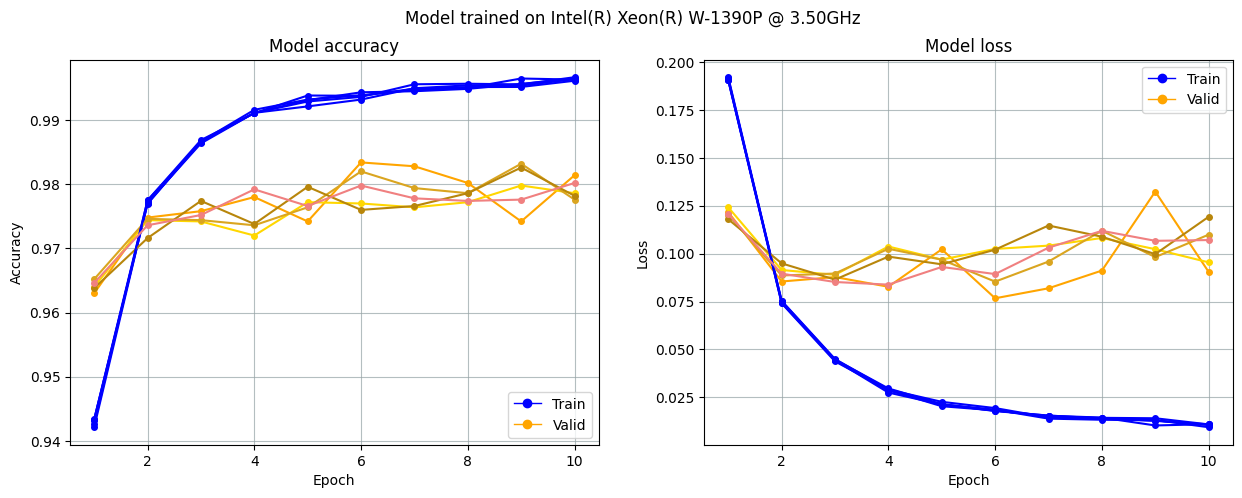

In [35]:
H, t0 = [], time()
print("training ", end="")

for i in range(5):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_DNN()
    
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=10,        # the total number of successive trainings
                     batch_size=32,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

The `val_loss` and `val_accuracy` differ at each of the 3 training.<br>
It can be a problem if we use a _callback_ like __early stoppping__ : the training will stop at a different epoch if we run the training many times.

### Load the same model weights at each iteration $\leadsto$ not reproducible

training  #1 #2 #3 #4 #5 Total Train Elapsed time 186s -> 00:03:06


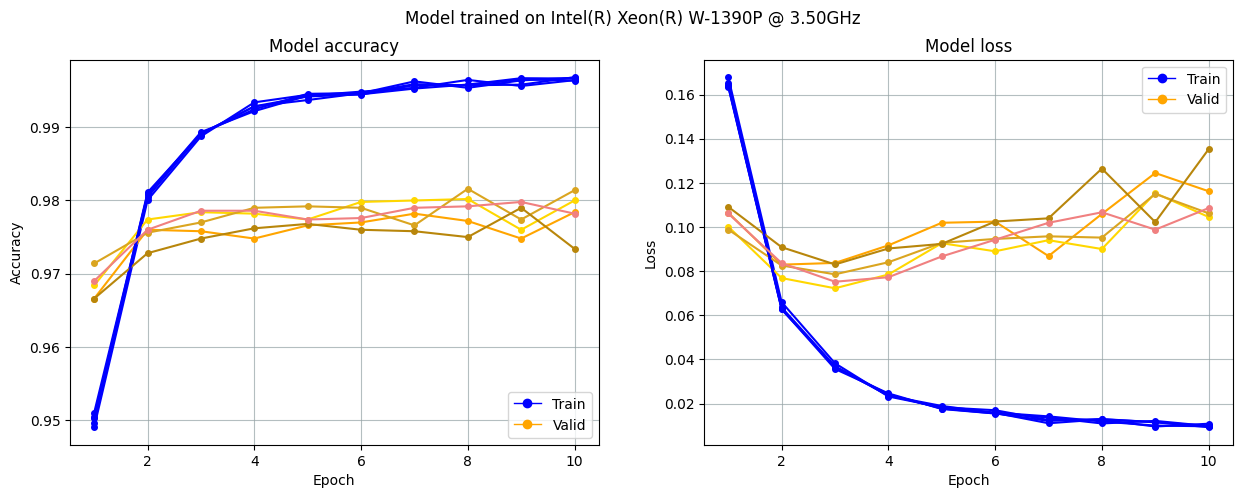

In [36]:
H, t0 = [], time()
print("training ", end="")

for i in range(5):
    print(f" #{i+1}", end="")
        
    # reload the structure of the NN and its initial state 
    model.load_weights('weights/DNN_relu_noseed.weights.h5') 
        
    # train the network
    hist = model.fit(x_train, y_train, 
                     epochs=10, 
                     batch_size=32,
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

The `val_loss` and `val_accuracy` differ at each training.<br>
It can be a problem if we use a _callback_ like __early stoppping__ : the training will stop at a different epoch if we run the training many times.

### Running several identical training with the tensorflow seed set $\leadsto$ reproducible

training  #1 #2 #3 #4 #5 Total Train Elapsed time 186s -> 00:03:06


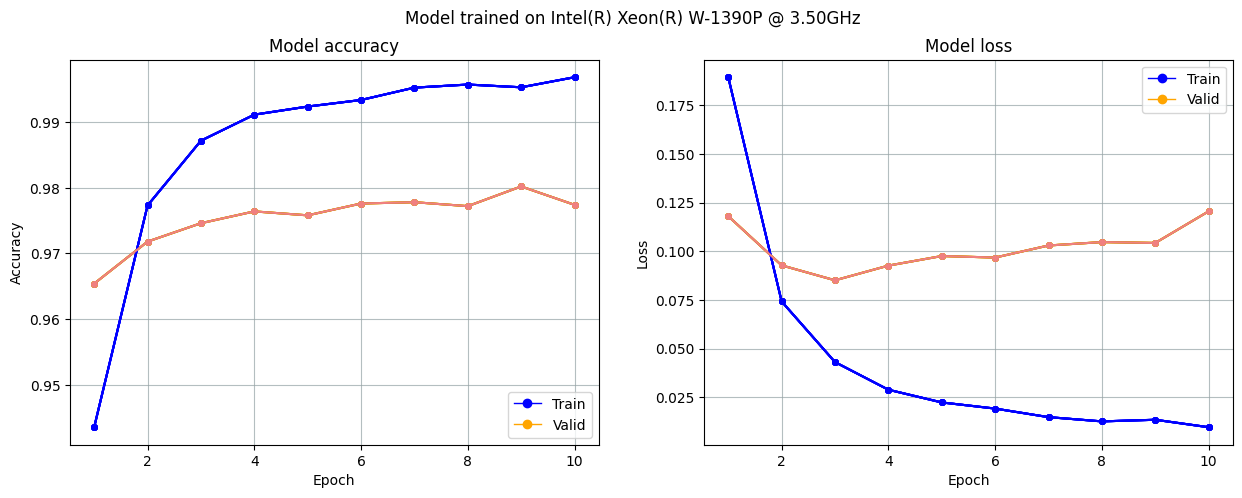

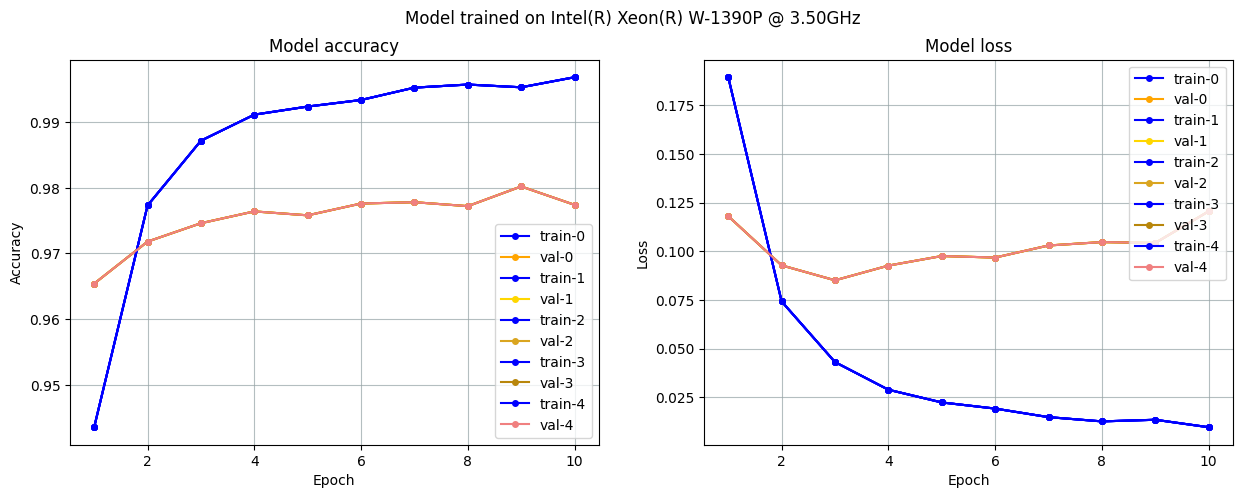

In [41]:
H, t0 = [], time()
print("training ", end="")

for i in range(5):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_DNN(1234)
    
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=10,        # the total number of successive trainings
                     batch_size=32,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 
plot_loss_accuracy(H, single_legend=False) 

$\leadsto$ the repoducibility is perfect &#128526;

### Load the same model structure & weights + set the tf seed at each iteration $\leadsto$ reproducible

training  #1 #2 #3 #4 #5 Total Train Elapsed time 192s -> 00:03:12


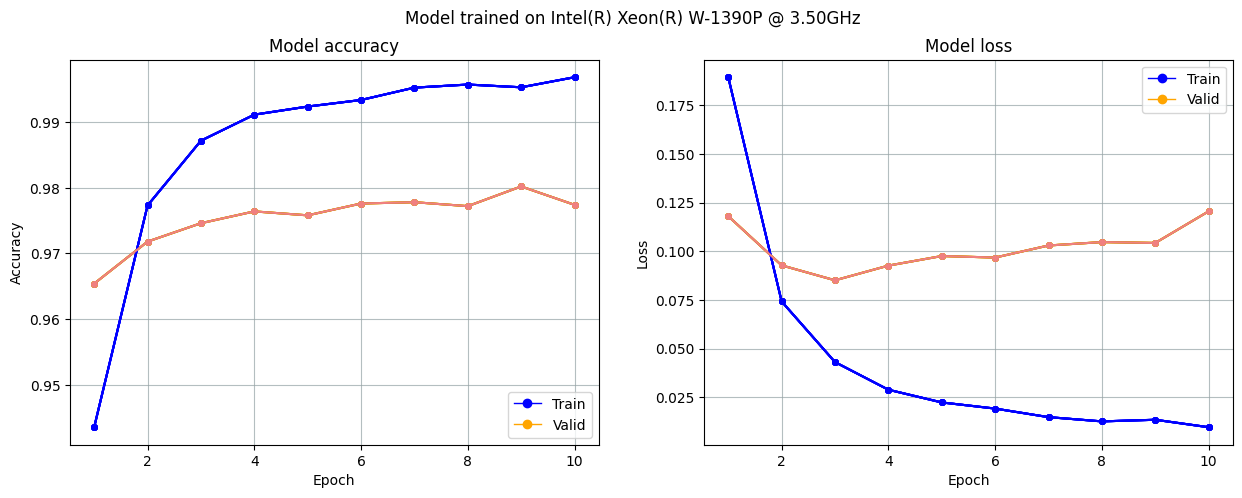

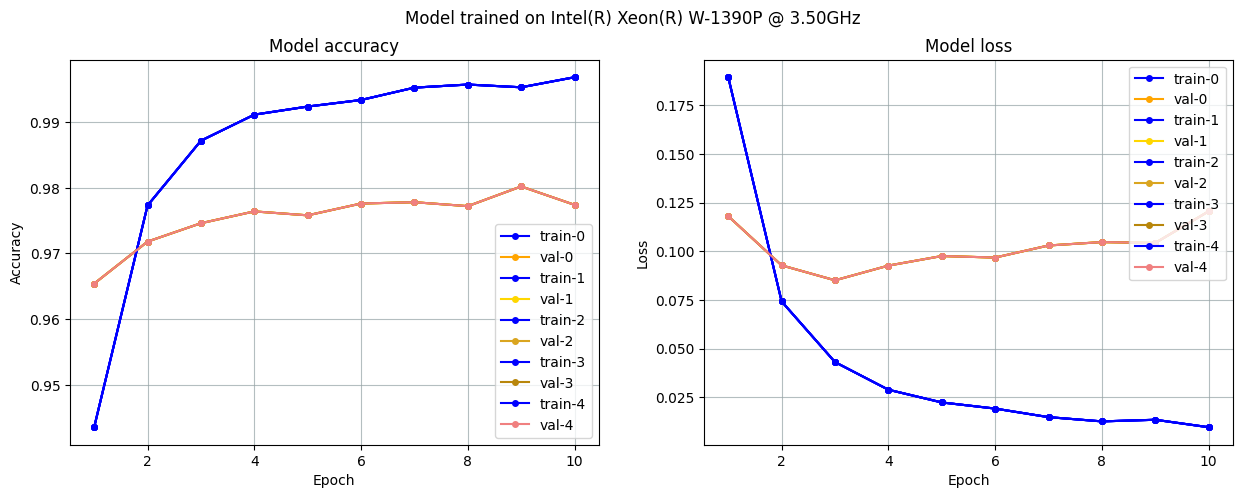

In [42]:
H, t0 = [], time()
print("training ", end="")

for i in range(5):
    print(f" #{i+1}", end="")
                
    # reload the structure of the NN and its initial state 
    model = tf.keras.models.load_model('models/DNN_relu_seed1234.keras') 
    
    # set the seed at each turn of the loop:
    tf.random.set_seed(1234)
    
    # train the network
    hist = model.fit(x_train, y_train, 
                     epochs=10, 
                     batch_size=32,
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 
plot_loss_accuracy(H, single_legend=False) 

Now that the training is reproducible it makes sens to study the influnece of some meta-parameters (n_epoch, batch_size...) on the performance of the trained network.

# Other interesting resources... videos:

In [55]:
%%HTML
<iframe src="https://www.youtube.com/embed/trWrEWfhTVg" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [56]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [57]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [58]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>